In [1]:
import pandas as pd
import numpy as np

### Checks on base TinyBERT model

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

checkpoint = 'huawei-noah/TinyBERT_General_4L_312D'
# checkpoint = 'albert/albert-large-v2' #req bs16 othw vram, and training v slow
# checkpoint = 'albert/albert-base-v2'

model = AutoModelForMaskedLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

display(
    checkpoint,
    model,
)

print(
    sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6,
    'million params'
)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


'huawei-noah/TinyBERT_General_4L_312D'

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise

14.381394 million params


Set `tokenizer.model_max_length`

In [3]:
if not getattr(tokenizer, 'model_max_length', None) == 512:
    tokenizer.model_max_length = 512
tokenizer

BertTokenizerFast(name_or_path='huawei-noah/TinyBERT_General_4L_312D', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [4]:
mask_token = tokenizer.special_tokens_map['mask_token']
text = f'It was a movie about {mask_token}.'

display(
    tokenizer(text),
    tokenizer.decode( tokenizer(text)['input_ids'] ),
    model(**tokenizer(text, return_tensors='pt')),
)

outputs = model(**tokenizer(text, return_tensors='pt'))
print('LM head output shape:', outputs.logits.shape)

logits = outputs['logits'] #(B, L, vocab)

#mask_id = tokenizer.convert_tokens_to_ids(mask_token)
mask_id = tokenizer.vocab[mask_token]
mask_ix = tokenizer(text).input_ids.index(mask_id)

print(tokenizer.decode(
    logits.detach().numpy()[0, mask_ix].argsort()[::-1][:5]
))

{'input_ids': [101, 2009, 2001, 1037, 3185, 2055, 103, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

'[CLS] it was a movie about [MASK]. [SEP]'

MaskedLMOutput(loss=None, logits=tensor([[[ 0.0395,  0.7269,  0.2387,  ...,  0.8403,  0.8712,  0.4771],
         [-0.0463,  0.1668,  0.1976,  ..., -0.0349,  0.2082,  0.0940],
         [-0.0659, -0.1432, -0.1890,  ...,  0.0323,  0.2478,  0.3310],
         ...,
         [-0.0183, -0.1747, -0.1914,  ...,  0.0553, -0.0635,  0.6340],
         [ 0.0674,  1.1103,  0.7440,  ...,  0.3351,  0.0164,  0.2027],
         [ 0.0752,  1.0598,  0.7429,  ...,  0.3009,  0.0412,  0.3249]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

LM head output shape: torch.Size([1, 9, 30522])
www https oh previously http


---
# **Fine-tune on SST**

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

if not getattr(tokenizer, 'model_max_length', None) == 512:
    tokenizer.model_max_length = 512

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

### Load SST5 data

SST5
https://github.com/CS287/HW1/tree/master/data

(0: very negative, 1: negative, 2: neutral, 3: positive, 4: very positive)

Drop test set aot combining with train|val

In [6]:
from datasets import load_dataset

# datasets = load_dataset('glue', 'sst2')
# datasets = load_dataset('stanfordnlp/sentiment140', trust_remote_code=True)
# datasets = load_dataset('stanfordnlp/sst', trust_remote_code=True)
datasets = load_dataset('SetFit/sst5')
datasets.pop('test')
display(datasets)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
})

Swap labels around. Want sst 0,1,2,3,4 neg:pos -> fft (4, 3, 2, 1, 0) neg:pos

In [7]:
sst5_to_fft = {
    0: 4, #v neg
    1: 3,
    2: 2,
    3: 1,
    4: 0, #v pos
}
datasets = datasets.map(
    lambda batch: {'fft_labels': [sst5_to_fft[sst_score] for sst_score in batch['label']]},
    batched=True
).rename_column('label', 'sst5_labels')
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'sst5_labels', 'label_text', 'fft_labels'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'sst5_labels', 'label_text', 'fft_labels'],
        num_rows: 1101
    })
})

Samples from dataset

In [8]:
datasets['train'].shuffle()[:2]

{'text': ["circuit queens wo n't learn a thing , they 'll be too busy cursing the film 's strategically placed white sheets .",
  "if you ignore the cliches and concentrate on city by the sea 's interpersonal drama , it ai n't half-bad ."],
 'sst5_labels': [2, 2],
 'label_text': ['neutral', 'neutral'],
 'fft_labels': [2, 2]}

Distribution of labels

Class 4 relatively small. Will use class weights to boost scores.

In [9]:
datasets.set_format('pandas')
datasets['train'][:].fft_labels.value_counts(normalize=True).mul(100).sort_index().round().pipe(display)
datasets.reset_format()

fft_labels
0    15.0
1    27.0
2    19.0
3    26.0
4    13.0
Name: proportion, dtype: float64

Tokenize and drop columns

In [10]:
tokenized = datasets\
    .map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True)\
    .remove_columns(['text', 'label_text', 'sst5_labels'])\
    .rename_column('fft_labels', 'labels')

if 'token_type_ids' in datasets['train'].column_names:
    tokenized = tokenized.remove_column('token_type_ids')
    
tokenized

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1101
    })
})

In [11]:
from copy import deepcopy

#Swap out the classifiation head for a new 5-class head.
# Could alternatively use .from_trained(..., ignore_mismatched_sizes=True),
# but seems undocumented as of yet.
dbert_base = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=5)

if False:
    [new_preclf] = [module for name, module in dbert_base.named_modules() if name == 'pre_classifier']
    [new_clf] = [module for name, module in dbert_base.named_modules() if name == 'classifier']

    dbert_ft = AutoModelForSequenceClassification.from_pretrained(
        'distilbert/distilbert-base-uncased-finetuned-sst-2-english' #, num_labels=5, ignore_mismatched_sizes=True
    )
    dbert_ft.pre_classifier = deepcopy(new_preclf)
    dbert_ft.classifier = deepcopy(new_clf)

    del dbert_base, new_preclf, new_clf

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-tune on SST5, then data

In [12]:
import torch
from torch.utils.data import DataLoader

from transformers import DataCollatorWithPadding
from transformers import get_scheduler

from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.utils import compute_class_weight

from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, ' GPU name:', torch.cuda.get_device_name())

from model_utils import compute_metrics

Device is: cuda  GPU name: NVIDIA GeForce RTX 4080 SUPER


SST5 fine-tuning

Class4 better with class balancing but rest v bad

If boost class4 and keep others 1, ok

In [13]:
torch.manual_seed(0)
np.random.seed(0)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5).to(device)
model.config.id2label = {clas: label for clas, label in enumerate(['very positive', 'positive', 'neutral', 'negative', 'very negative'])}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

#Class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2, 3, 4]), y=tokenized['train'][:]['labels'])
class_weights = None
class_weights = np.array([1., 1., 1., 1., 2.])

if class_weights is not None:
    print('[!] Using class weights:', class_weights.round(1))

#Data loaders
batch_size = 16

dynamic_padding_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(
    tokenized['train'], batch_size=batch_size, shuffle=True,
    pin_memory=True, collate_fn=dynamic_padding_collator
)

val_loader = DataLoader(
    tokenized['validation'], batch_size=batch_size,
    pin_memory=True, collate_fn=dynamic_padding_collator
)

val_labels = np.concatenate([minibatch['labels'] for minibatch in val_loader])


#LR scheduler
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
print(num_epochs, 'epochs |', num_training_steps, 'training steps')

lr_scheduler = get_scheduler(
    'linear', optimizer,
    num_warmup_steps=int(round(0.1 * num_training_steps)),
    num_training_steps=num_training_steps
)


#Score before training
preds, loss = compute_metrics(model, val_loader, device)
print('Prior to fine-tuning'.center(85, '~'))
print(classification_report(y_true=val_labels, y_pred=preds, zero_division=np.nan))
print('  loss:', loss)


#
# Training loop
#
writer = SummaryWriter(log_dir='runs/tinybert_ft_sst5/' + f'bs{batch_size}-cw4')

progress_bar = tqdm(range(num_training_steps), unit='minibatch', desc='train steps')
for epoch in range(num_epochs):
    model.train()

    for minibatch in train_loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}
        outputs = model(**minibatch)

        loss = outputs.loss
        
        optimizer.zero_grad()
        # outputs.loss.backward()
        torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device).float())(outputs['logits'], minibatch['labels']).backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update()
    #/end of epoch

    model.eval()
    trn_preds, trn_loss = compute_metrics(model, train_loader, device)
    val_preds, val_loss = compute_metrics(model, val_loader, device)

    print(f'(epoch {epoch + 1:2d}) | trn {trn_loss:6.4f} | val {val_loss:6.4f}')

    writer.add_scalars('loss', {'trn': trn_loss, 'val': val_loss}, global_step=epoch + 1)
    
    #Class k metrics
    k = 4
    class_k_true = val_labels==k
    class_k_pred = val_preds==k
    writer.add_scalars(
        f'class {k} val metrics',
        {#'recall': recall_score(class_k_true, class_k_pred),
         'f1': f1_score(class_k_true, class_k_pred)
         },
         global_step=epoch + 1
    )

    clf_report = classification_report(val_labels, val_preds, zero_division=np.nan)
    writer.add_text('classification_report', clf_report, global_step=epoch + 1)
torch.save(model.state_dict(), f'finetuned/tinybert-sst5.pickle')

print(clf_report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[!] Using class weights: [1. 1. 1. 1. 2.]
10 epochs | 5340 training steps
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Prior to fine-tuning~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0        nan      0.00      0.00       165
           1       0.26      0.99      0.41       279
           2        nan      0.00      0.00       229
           3        nan      0.00      0.00       289
           4       0.30      0.04      0.08       139

    accuracy                           0.26      1101
   macro avg       0.28      0.21      0.10      1101
weighted avg       0.27      0.26      0.11      1101

  loss: 1.6086374247323156


train steps:   0%|          | 0/5340 [00:00<?, ?minibatch/s]

(epoch  1) | trn 1.3465 | val 1.3567
(epoch  2) | trn 1.1758 | val 1.2364
(epoch  3) | trn 1.1061 | val 1.2055
(epoch  4) | trn 1.0590 | val 1.2060
(epoch  5) | trn 1.0339 | val 1.2243
(epoch  6) | trn 0.9827 | val 1.2178
(epoch  7) | trn 0.9558 | val 1.2215
(epoch  8) | trn 0.9402 | val 1.2360
(epoch  9) | trn 0.9327 | val 1.2382
(epoch 10) | trn 0.9181 | val 1.2345
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       165
           1       0.48      0.62      0.54       279
           2       0.43      0.23      0.30       229
           3       0.51      0.43      0.46       289
           4       0.42      0.63      0.50       139

    accuracy                           0.48      1101
   macro avg       0.48      0.49      0.47      1101
weighted avg       0.48      0.48      0.47      1101



In [14]:
"""
tinybert bs16
              precision    recall  f1-score   support
           0       0.55      0.56      0.55       165
           1       0.48      0.62      0.54       279
           2       0.43      0.23      0.30       229
           3       0.51      0.43      0.46       289
           4       0.42      0.63      0.50       139

    accuracy                           0.48      1101
   macro avg       0.48      0.49      0.47      1101
weighted avg       0.48      0.48      0.47      1101
"""

'\ntinybert bs16\n              precision    recall  f1-score   support\n           0       0.55      0.56      0.55       165\n           1       0.48      0.62      0.54       279\n           2       0.43      0.23      0.30       229\n           3       0.51      0.43      0.46       289\n           4       0.42      0.63      0.50       139\n\n    accuracy                           0.48      1101\n   macro avg       0.48      0.49      0.47      1101\nweighted avg       0.48      0.48      0.47      1101\n'

In [15]:
from model_utils import pipeline_results_to_df, logits_to_df

texts = ['perfect!', 'good', 'meh', 'i dont like it', 'i hate it!',]

#
# Using pipeline
#
from transformers import pipeline

if False:
    pl = pipeline('sentiment-analysis', model, tokenizer=tokenizer, top_k=None)
    ans = pl(texts)
    display(ans)

    pipeline_results_to_df(ans, model.config.label2id)\
        .style\
        .text_gradient(subset=['very positive', 'positive', 'neutral', 'very negative', 'negative'], axis=1, cmap='Purples_r')


#
# Using logits
#
with torch.no_grad():
    logits = model(**tokenizer(texts, padding=True, return_tensors='pt').to(device))['logits']

logits_to_df(logits.cpu(), model.config.id2label)\
    .style\
    .text_gradient(subset=['very positive', 'positive', 'neutral', 'very negative', 'negative'], axis=1, cmap='Purples_r')

,very positive,positive,neutral,negative,very negative,entropy,predicted_label,predicted_id
0,0.517138,0.435383,0.035969,0.007010,0.004499,1.272088,very positive,0
1,0.215806,0.678828,0.087168,0.014746,0.003452,1.281563,positive,1
2,0.015028,0.149321,0.437891,0.346310,0.051451,1.772412,neutral,2
3,0.009685,0.063449,0.309403,0.478728,0.138735,1.744949,negative,3
4,0.016091,0.007457,0.028653,0.138069,0.809729,0.936368,very negative,4


---
# **Sentiment data**

In [16]:
from spreadsheet_data_handling import tweak_for_sentiment
from sklearn.model_selection import train_test_split

#Could use tweak_generic for MLM/domain-adaptation, but stick to
# tweak_for_sentiment to be consistent with previous data splits
tweaked_df = (
    pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv')
    .pipe(tweak_for_sentiment)
)

tweaked_df, test_df = train_test_split(
    tweaked_df, test_size=0.15,
    random_state=0,
    stratify=tweaked_df['Comment sentiment']
)

tweaked_df.style\
    .set_caption(f'shape: {tweaked_df.shape}')\
    .background_gradient(subset=['Comment sentiment'], cmap='RdYlGn_r')\
    .hide(subset=tweaked_df.sample(n=len(tweaked_df) - 5).index)

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
4772,NEAS PTS 1957 - Q1,NEAS,NEAS PTS 1957,30/09/2022,nonspecific,Usually pick up on time but on occasion quite late and all occasion so late my appointment with consultant was put in jeopardy.,127,23,4,negative
4765,NEAS PTS 1936 - Q1,NEAS,NEAS PTS 1936,30/09/2022,nonspecific,Quicker response to return home.,32,5,4,negative
3439,NEAS PTS 903 - Q2,NEAS,NEAS PTS 903,31/01/2022,could_improve,As far as I know it was the best. Seeing the other ambulance did not turn up at all that's why you were called you came quick. Many thanks.,139,29,2,positive
3107,NEAS 111 2015 - Q2,NEAS,NEAS 111 2015,10/05/2022,could_improve,Got a prompt response and appointment within 1 hour,51,9,2,positive
2738,NHFT 1341 - Q2,NHFT,NHFT 1341,14/03/2022,what_good,Yes.,4,1,3,neutral


### Stratified train-val split and to `DatasetDict`

In [17]:
from datasets import Dataset, DatasetDict

fft_df_trn, fft_df_val = train_test_split(
    tweaked_df, test_size=1/4, random_state=0,
    stratify=tweaked_df['Comment sentiment']
)

fft_datasets = DatasetDict({
    'train': Dataset.from_pandas(fft_df_trn),
    'validation': Dataset.from_pandas(fft_df_val),
    'test': Dataset.from_pandas(test_df)
}).remove_columns([
    'Comment ID', 'Trust', 'Respondent ID', 'Date',
    'answer_char_len', 'answer_word_len', '__index_level_0__',
])

#Subtract 1 from score to get 0:4 for pos:neg
fft_datasets = fft_datasets.map(
    lambda batch:
    {'comment_sentiment': [score - 1 for score in batch['Comment sentiment']]},
    batched=True
).remove_columns(['Comment sentiment',])

display(fft_datasets)


#View sample
fft_datasets['train'].shuffle()[:2]

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question_type', 'answer_clean', 'sentiment_desc', 'comment_sentiment'],
        num_rows: 3929
    })
    validation: Dataset({
        features: ['question_type', 'answer_clean', 'sentiment_desc', 'comment_sentiment'],
        num_rows: 1310
    })
    test: Dataset({
        features: ['question_type', 'answer_clean', 'sentiment_desc', 'comment_sentiment'],
        num_rows: 925
    })
})

{'question_type': ['could_improve', 'could_improve'],
 'answer_clean': ['Only that other participants sometimes had background sounds.',
  "In the present circumstances, with fewer staff, and the public's lack of appreciation I felt I had to mention what I thought was an outstanding person who went above and beyond. A gentleman"],
 'sentiment_desc': ['negative', 'very positive'],
 'comment_sentiment': [3, 0]}

Rather than learning new token embeddings for question types, start by leveraging existing tokens.

In [18]:
from model_utils import combine_question_answer

fft_datasets = fft_datasets.map(combine_question_answer, batched=True)
fft_datasets['train'].shuffle()[:1]

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

{'question_type': ['could_improve'],
 'answer_clean': ["They couldn't have done anything better."],
 'sentiment_desc': ['very positive'],
 'comment_sentiment': [0],
 'q_and_a': ["Question: What could be improved? Answer: They couldn't have done anything better."]}

Tokenize

In [19]:
fft_tokenized = fft_datasets.map(
    lambda batch: tokenizer(batch['q_and_a'], padding=False, truncation=True),
    batched=True
).remove_columns([
    'question_type', 'answer_clean', 'sentiment_desc', 'q_and_a',
]).rename_column('comment_sentiment', 'labels')

if 'token_type_ids' in fft_tokenized['train']:
    fft_tokenized = fft_tokenized.remove_column('token_type_ids')

fft_tokenized['train'].shuffle()[:1].keys()

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

Fine-tune model on FFT data

Regular class-balancing helps

In [20]:
np.random.seed(10)
torch.manual_seed(10)

#Load weights into clean model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
model.load_state_dict(torch.load('finetuned/tinybert-sst5.pickle', weights_only=True))
model.to(device)

#Run on DistilBERT for comparison to approach in pxtextmining
# model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=5)
# model.to(device)

#Class weights
class_weights = None
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2, 3, 4]), y=fft_tokenized['train'][:]['labels'])

if class_weights is not None:
    print('[!] Class weights', class_weights.round(1))


#Data loaders
batch_size = 4

dynamic_padding_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(
    fft_tokenized['train'],
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=dynamic_padding_collator,
)

val_loader = DataLoader(
    fft_tokenized['validation'],
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=dynamic_padding_collator,
)
val_labels = np.concatenate([minibatch['labels'] for minibatch in val_loader])

test_loader = DataLoader(
    fft_tokenized['test'],
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=dynamic_padding_collator
)

#Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 19
earlystop_at_epoch = 9

num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    'linear',
    optimizer,
    num_warmup_steps=int(round(0.1 * num_training_steps)),
    num_training_steps=num_training_steps,
)
print(num_epochs, 'epochs |', num_training_steps, 'training steps')


#Score before training
preds, loss = compute_metrics(model, val_loader, device)
print('Before FFT fine-tuning'.center(85, '~'))
print(classification_report(val_labels, preds))


progress_bar = tqdm(range(num_training_steps), unit='minibatch', desc='training')
writer = SummaryWriter(f'runs/fft_ft-bs{batch_size}')

#
# Training loop
#
for epoch in range(num_epochs):
    model.train()

    for minibatch in train_loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}
        outputs = model(**minibatch)

        optimizer.zero_grad()
        # outputs.loss.backward()
        torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))(outputs['logits'], minibatch['labels']).backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update()
    #/end of epoch

    model.eval()
    trn_preds, trn_loss = compute_metrics(model, train_loader, device)
    val_preds, val_loss = compute_metrics(model, val_loader, device)

    writer.add_scalars('loss', {'train': trn_loss, 'val': val_loss}, global_step=epoch + 1)
    
    clf_report = classification_report(val_labels, val_preds, zero_division=np.nan)
    writer.add_text('classification_report', clf_report, global_step=epoch + 1)

    if epoch + 1 == earlystop_at_epoch: break

torch.save(model.state_dict(), f'finetuned/tinybert-sst5-fft.pickle')

print(clf_report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[!] Class weights [0.5 0.9 1.7 0.9 4.8]
19 epochs | 18677 training steps
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Before FFT fine-tuning~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0       0.78      0.19      0.30       512
           1       0.40      0.65      0.49       300
           2       0.20      0.26      0.23       152
           3       0.30      0.37      0.33       291
           4       0.16      0.40      0.23        55

    accuracy                           0.35      1310
   macro avg       0.37      0.37      0.32      1310
weighted avg       0.49      0.35      0.34      1310



training:   0%|          | 0/18677 [00:00<?, ?minibatch/s]

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       512
           1       0.59      0.68      0.63       300
           2       0.53      0.43      0.48       152
           3       0.82      0.75      0.78       291
           4       0.58      0.69      0.63        55

    accuracy                           0.71      1310
   macro avg       0.67      0.67      0.67      1310
weighted avg       0.72      0.71      0.71      1310



In [ ]:
"""
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       512
           1       0.59      0.68      0.63       300
           2       0.53      0.43      0.48       152
           3       0.82      0.75      0.78       291
           4       0.58      0.69      0.63        55

    accuracy                           0.71      1310
   macro avg       0.67      0.67      0.67      1310
weighted avg       0.72      0.71      0.71      1310
"""

### Threshold tuning

Seems like there's scope to tune it to ~0.7 (for class 4 atleast)

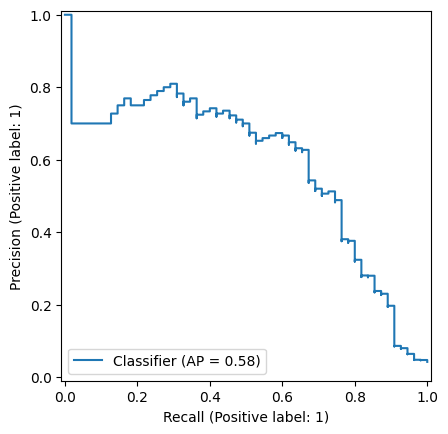

In [21]:
model.eval()

with torch.no_grad():
    val_logits = torch.row_stack([model(**{k: v.to(device) for k, v in minibatch.items()}).logits for minibatch in val_loader])

from sklearn.metrics import PrecisionRecallDisplay

k = 4
PrecisionRecallDisplay.from_predictions(val_labels==k, val_logits.softmax(dim=1).cpu()[:, k])

### Test set score

In [22]:
# model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=5)
# model.load_state_dict(torch.load('finetuned/distilbert-fft.pickle', weights_only=True))

model.eval()
test_preds, test_loss = compute_metrics(model, test_loader, device)

print(classification_report(
    y_true=np.concatenate([minibatch['labels'] for minibatch in test_loader]),
    y_pred=test_preds
))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       362
           1       0.60      0.69      0.64       212
           2       0.39      0.38      0.38       108
           3       0.80      0.76      0.78       205
           4       0.69      0.53      0.60        38

    accuracy                           0.71       925
   macro avg       0.66      0.63      0.64       925
weighted avg       0.71      0.71      0.71       925



In [ ]:
"""
tinybert-sst5-fft
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       362
           1       0.60      0.69      0.64       212
           2       0.39      0.38      0.38       108
           3       0.80      0.76      0.78       205
           4       0.69      0.53      0.60        38

    accuracy                           0.71       925
   macro avg       0.66      0.63      0.64       925
weighted avg       0.71      0.71      0.71       925


fft directly finetuned base distilbert (6 epochs)
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       362
           1       0.62      0.67      0.64       212
           2       0.38      0.46      0.42       108
           3       0.84      0.73      0.78       205
           4       0.50      0.68      0.58        38

    accuracy                           0.70       925
   macro avg       0.64      0.67      0.65       925
weighted avg       0.72      0.70      0.71       925


copy of pxtextmining/distilbert sentiment score
               precision    recall  f1-score   support

very positive       0.80      0.79      0.80      1746
     positive       0.63      0.52      0.57       841
      neutral       0.52      0.71      0.60       551
     negative       0.79      0.68      0.73       639
very negative       0.52      0.64      0.57       166

     accuracy                           0.70      3943
    macro avg       0.65      0.67      0.65      3943
 weighted avg       0.71      0.70      0.70      3943
 """